In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Choose Dataset

In [2]:
DATASET = 'mnist'
if DATASET     == 'mnist':
    epochs     = 50
    #lr         = 0.00004
    lr         = 0.01
    momentum   = 0.0    
    mean_imgs  = 0.1307
    std_imgs   = 0.3081
    imgs_shape = (1,28,28)

In [3]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
RES = os.path.join(ROOT,'results')

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm

from mnist_archs import LeNet
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [5]:
bs = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print(kwargs)

{'num_workers': 2, 'pin_memory': True}


In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(ROOT +  '/data/' + DATASET, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                                           
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    
    datasets.MNIST(ROOT + '/data/' + DATASET, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                       
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

In [7]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])


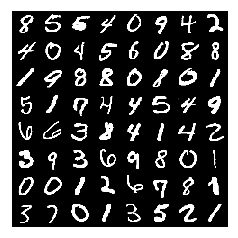

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/queues.

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

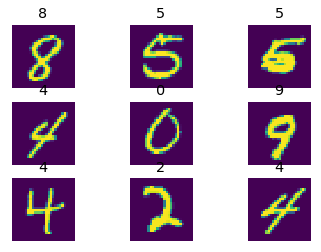

In [9]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

# Initialize network, optimizer and loss

In [10]:
model = LeNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = F.nll_loss

In [11]:
print(model)
print( summary(model, imgs_shape) )

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]            5020
            Linear-3                   [-1, 50]           16050
            Linear-4                   [-1, 10]             510
Total params: tensor(21840)
Trainable params: tensor(21840)
Non-trainable params: tensor(0)
----------------------------------------------------------------
None


In [16]:
train_loss   = []
train_acc    = []
valid_loss   = []
valid_acc    = []

In [17]:
for epoch in tqdm(range(epochs)):
    
    # init auxiliary grad and grad2
    auxgrad  = init_grad(model)
    auxgrad2 = init_grad(model)
    
        
    num_mb = 0
    for i, data in enumerate(train_loader, 0):
        
        num_mb += 1
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        auxgrad  = acc_grad(auxgrad,model)
        auxgrad2 = acc_grad2(auxgrad2,model)
        
    
    # compute the snr 
    snr = compute_snr(auxgrad, auxgrad2, num_mb) 
    
    # temper the grad with the information on grad2
    with torch.no_grad():
        for param, s in zip(model.parameters(), snr): 
            param.grad[s < 1] = 0.0
       
    # this is now outside (modify learning rate accordingly ???)
    optimizer.step()
        
        
    # save model
    torch.save(model, RES + 'model_' + str(epoch) + '.pt')
        
    # print statistics
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        valid_loss.append(l)
    
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        train_loss.append(l)        
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        valid_acc.append(acc)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        train_acc.append(acc)
        
    # print statistics
    print('Test loss : %g --- Test acc : %g %%' % ( valid_loss[-1], valid_acc[-1] )) 
    

# save loss and accuracies in a dictionary
tags = ['train_loss','valid_loss', 'train_acc', 'valid_acc' ]
vals = [train_loss, valid_loss, train_acc, valid_acc]
training_data = dict(zip(tags, vals))
file = open(RES + "training_data",'wb')
pickle.dump(training_data,file)
print('Finished training.')


  2%|▏         | 1/50 [00:07<06:04,  7.44s/it]

Test loss : 0.0361517 --- Test acc : 10.33 %



  4%|▍         | 2/50 [00:15<06:03,  7.57s/it]

Test loss : 0.0360615 --- Test acc : 10.9 %



  6%|▌         | 3/50 [00:22<05:53,  7.53s/it]

Test loss : 0.0359018 --- Test acc : 17.51 %



  8%|▊         | 4/50 [00:30<05:48,  7.58s/it]

Test loss : 0.0357437 --- Test acc : 21.46 %



 10%|█         | 5/50 [00:37<05:40,  7.57s/it]

Test loss : 0.0355718 --- Test acc : 21.13 %



 12%|█▏        | 6/50 [00:45<05:34,  7.60s/it]

Test loss : 0.0354456 --- Test acc : 29.62 %



 14%|█▍        | 7/50 [00:53<05:27,  7.61s/it]

Test loss : 0.035294 --- Test acc : 19.83 %



 16%|█▌        | 8/50 [01:00<05:18,  7.59s/it]

Test loss : 0.035065 --- Test acc : 28.58 %



 18%|█▊        | 9/50 [01:08<05:11,  7.60s/it]

Test loss : 0.034893 --- Test acc : 19.3 %



 20%|██        | 10/50 [01:15<05:03,  7.59s/it]

Test loss : 0.034539 --- Test acc : 30.77 %



 22%|██▏       | 11/50 [01:23<04:55,  7.59s/it]

Test loss : 0.0342168 --- Test acc : 37.97 %



 24%|██▍       | 12/50 [01:30<04:47,  7.57s/it]

Test loss : 0.0338466 --- Test acc : 41.59 %



 26%|██▌       | 13/50 [01:38<04:39,  7.56s/it]

Test loss : 0.0330634 --- Test acc : 35.16 %



 28%|██▊       | 14/50 [01:45<04:32,  7.56s/it]

Test loss : 0.0323621 --- Test acc : 25.77 %



 30%|███       | 15/50 [01:53<04:24,  7.56s/it]

Test loss : 0.0319523 --- Test acc : 34.01 %



 32%|███▏      | 16/50 [02:00<04:16,  7.55s/it]

Test loss : 0.030892 --- Test acc : 44.04 %



 34%|███▍      | 17/50 [02:08<04:09,  7.55s/it]

Test loss : 0.0308265 --- Test acc : 36.46 %



 36%|███▌      | 18/50 [02:16<04:02,  7.56s/it]

Test loss : 0.0286578 --- Test acc : 45.38 %



 38%|███▊      | 19/50 [02:23<03:54,  7.56s/it]

Test loss : 0.0276348 --- Test acc : 42.44 %



 40%|████      | 20/50 [02:31<03:47,  7.57s/it]

Test loss : 0.032054 --- Test acc : 32.39 %



 42%|████▏     | 21/50 [02:39<03:39,  7.57s/it]

Test loss : 0.0316156 --- Test acc : 26.67 %



 44%|████▍     | 22/50 [02:46<03:31,  7.56s/it]

Test loss : 0.0296695 --- Test acc : 41.38 %



 46%|████▌     | 23/50 [02:53<03:24,  7.56s/it]

Test loss : 0.0270916 --- Test acc : 46.97 %



 48%|████▊     | 24/50 [03:01<03:16,  7.56s/it]

Test loss : 0.0251314 --- Test acc : 47.25 %


Process Process-243:
Process Process-244:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = self.transform(img)
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/t